## Execution of machine translation and code reading

In [14]:
'''Sequence to sequence example in Keras (character-level).
This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.
# Summary of the algorithm:
- We start with input sequences from a domain (e.g. English sentences)
    and correspding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    Is uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
# Data download:
English to French sentence pairs.
https://www.manythings.org/anki/fra-eng.zip
Lots of neat sentence pairs datasets can be found at:
https://www.manythings.org/anki/
# References:
- Sequence to Sequence Learning with Neural Networks
    https://arxiv.org/abs/1409.3215
- Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    https://arxiv.org/abs/1406.1078
'''
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
lines = open(data_path).read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text,_ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 92
Max sequence length for inputs: 15
Max sequence length for outputs: 59
Epoch 1/100
125/125 [==============================] - 46s 344ms/step - loss: 0.9712 - val_loss: 1.0774
Epoch 2/100
125/125 [==============================] - 43s 345ms/step - loss: 0.9071 - val_loss: 1.0407
Epoch 3/100
125/125 [==============================] - 43s 340ms/step - loss: 0.8599 - val_loss: 0.9764
Epoch 4/100
125/125 [==============================] - 42s 340ms/step - loss: 0.8195 - val_loss: 0.9531
Epoch 5/100
125/125 [==============================] - 42s 340ms/step - loss: 0.7884 - val_loss: 0.9184
Epoch 6/100
125/125 [==============================] - 43s 341ms/step - loss: 0.7613 - val_loss: 0.8834
Epoch 7/100
125/125 [==============================] - 42s 339ms/step - loss: 0.7400 - val_loss: 0.9028
Epoch 8/100
125/125 [==============================] - 43s 341ms/step - loss: 0.7202 - val_loss: 0.8440
Epo

- Lines 51-55: Import library
- Lines 57-62: Hyperparameter Settings
- Lines 65-82: Preprocess data, data is divided in to 4 dataset , input_texts and target_texts which also add \t as "start sequence" character and \n as "end sequence",  input_characters and target_characters
- Line 84-95: sort characters ,get number of characters and max length of sentence in data
- Line 97-110: covert characters to number and texts to matrix
- Line 112-121: Assign value to the matrix
- Line 124-152: Define training process and save model 
- Line 163-174: Define sampling process
- Line 178-182: Reverse-lookup token index to decode sequences back to something readable
- Line 184 -219: decode function 
- Line 222 -229: show result of input sentence through decode function


##  Execution of a trained model of image captioning

In [2]:
!wget http://www.manythings.org/anki/fra-eng.zip

--2022-02-18 07:16:12--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 172.67.186.54, 104.21.92.44, 2606:4700:3033::ac43:ba36, ...
Connecting to www.manythings.org (www.manythings.org)|172.67.186.54|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6532197 (6.2M) [application/zip]
Saving to: ‘fra-eng.zip.1’

fra-eng.zip.1       100%[===================>]   6.23M  --.-KB/s    in 0.09s   

2022-02-18 07:16:13 (70.5 MB/s) - ‘fra-eng.zip.1’ saved [6532197/6532197]



In [11]:
!unzip fra-eng.zip

Archive:  fra-eng.zip
replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: _about.txt              
  inflating: fra.txt                 


In [1]:
!git clone https://github.com/pdollar/coco.git

Cloning into 'coco'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 28.38 MiB/s, done.
Resolving deltas: 100% (576/576), done.


In [2]:

%cd coco/PythonAPI/

/content/coco/PythonAPI


In [3]:
!make
!python setup.py build
!python setup.py install

python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/coco/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/pycocotools
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-pX47U3/python3.7-3.7.12=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-pX47U3/python3.7-3.7.12=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.7/dist-packages/numpy/core/include -

In [4]:
%cd ../../

/content


In [5]:
!git clone https://github.com/yunjey/pytorch-tutorial.git


Cloning into 'pytorch-tutorial'...
remote: Enumerating objects: 917, done.
remote: Total 917 (delta 0), reused 0 (delta 0), pack-reused 917
Receiving objects: 100% (917/917), 12.80 MiB | 35.24 MiB/s, done.
Resolving deltas: 100% (490/490), done.


In [1]:
%cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

/content/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [7]:
!pip install -r requirements.txt


In [5]:
!mv /content/download.png  /content/pytorch-tutorial/tutorials/03-advanced/image_captioning/download.png

In [4]:
!wget https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0

--2022-02-18 11:16:48--  https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ne0ixz5d58ccbbz/pretrained_model.zip [following]
--2022-02-18 11:16:49--  https://www.dropbox.com/s/raw/ne0ixz5d58ccbbz/pretrained_model.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc273477558a981f561db84dbebd.dl.dropboxusercontent.com/cd/0/inline/Bf8NCMiIFukhNQGubg3nzO3yBFxsiAPmbub5GXbrSlyVbfvmlSYqz4lPjeCRA-_zhyoGyQTTL3T1c9T85UhMm719IxLdk229NKpwsPksXAqn5UnHQ3KnPeH8Xl67E6l4p53BWFgkjm-E_YY2D8oqjFIP/file# [following]
--2022-02-18 11:16:49--  https://uc273477558a981f561db84dbebd.dl.dropboxusercontent.com/cd/0/inline/Bf8NCMiIFukhNQGubg3nzO3yBFxsiAPmbub5GXbrSlyVbfvmlSYqz4lPjeCRA

In [8]:
!unzip /content/pytorch-tutorial/tutorials/03-advanced/image_captioning/pretrained_model.zip?dl=0 -d ./models/

Archive:  /content/pytorch-tutorial/tutorials/03-advanced/image_captioning/pretrained_model.zip?dl=0
  inflating: ./models/encoder-5-3000.pkl  
  inflating: ./models/decoder-5-3000.pkl  


In [9]:
!wget https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip?dl=0

--2022-02-18 11:20:15--  https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/26adb7y9m98uisa/vocap.zip [following]
--2022-02-18 11:20:15--  https://www.dropbox.com/s/raw/26adb7y9m98uisa/vocap.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0060bdfdc4be2876e217fa62f5.dl.dropboxusercontent.com/cd/0/inline/Bf_KlhF_0v-75QmeRFDZkZs4hwalAz_YdXa2qr4CGdTgaFCz30h2wqFNFwFNiFhPbxI0tywAyonfKMnQRmzEMeJ8MCGtynFsvYGyMunb4OJRnLEtmTgOqYEc_OBXMLDuBg4_1Y3Pw8n46khZNJLmO9PQ/file# [following]
--2022-02-18 11:20:15--  https://uc0060bdfdc4be2876e217fa62f5.dl.dropboxusercontent.com/cd/0/inline/Bf_KlhF_0v-75QmeRFDZkZs4hwalAz_YdXa2qr4CGdTgaFCz30h2wqFNFwFNiFhPbxI0tywAyonfKMnQRmzEMeJ8MCGtyn

In [10]:
!unzip /content/pytorch-tutorial/tutorials/03-advanced/image_captioning/vocap.zip?dl=0 -d ./data/

Archive:  /content/pytorch-tutorial/tutorials/03-advanced/image_captioning/vocap.zip?dl=0
  inflating: ./data/vocab.pkl        


In [11]:
!python sample.py --image="/content/download.png"

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100% 230M/230M [00:03<00:00, 66.1MB/s]
<start> a group of people sitting on a bench in the woods . <end>


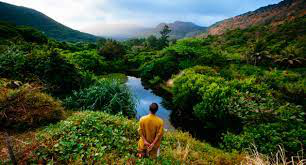

In [12]:
from PIL import Image
Image.open('/content/download.png')

##  Investigate what to do if you want to move with Keras

As far as i know , there are 3 way to move from pytorch to keras:
- First , we can use library pytorch2keras which can be found in github gmalivenko/pytorch2keras
- Second, we also can make the transfering through ONNX 
-Finally , we can do it ourselves by loading weights of model and tranpose weights to make it suitable for model in keras


## Code reading and rewriting

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet152
class EncoderCNN(tf.keras.Model):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = ResNet152()
        modules = tf.keras.Model(inputs=resnet.input, outputs=resnet.layers[-2].output) 
        modules.trainable = False 
           # delete the last fc layer.
        self.resnet = tf.keras.Sequential(*modules)
        self.linear = tf.keras.layers.Dense(embed_size)
        
        self.bn = tf.keras.layers.BatchNormalization(momentum=0.01)
        
    def call(self, images):
        """Extract feature vectors from input images."""
        
        features = self.resnet(images)
        features = features.reshape(features.shape(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(tf.keras.Model):
    def __init__(self, embed_size, hidden_size,vocab_size , num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.lstm = tf.keras.layers.LSTM(hidden_size)
        self.linear = tf.keras.layers.Dense(vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        # embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        embeddings = tf.concat([tf.expand_dims(features,axis = 1),embeddings],axis =1 )
        # packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        packed =embeddings
        hiddens = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = tf.expand_dims(features,axis = 1)
        # inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, initial_state = states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear( tf.expand_dims(hiddens,axis = 1))            # outputs:  (batch_size, vocab_size)
            predicted = tf.math.reduce_max(outputs,axis=1)                       # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = tf.expand_dims(inputs,axis = 1)                        # inputs: (batch_size, 1, embed_size)
        sampled_ids = tf.stack(sampled_ids, axis = 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

##  Developmental survey


### When translating into other languages?

There are 4 steps:
- Preprocessing: load and examine data, cleaning, tokenization, padding
- Modeling: build, train, and test the model
- Prediction: generate specific translations of English to French, and compare the output translations to the ground truth translations
- Iteration: iterate on the model, experimenting with different architectures

### What are the advanced methods of machine translation?

- DNN based
- CNN based
- Encoder-Decoder Structure

### How to generate an image from text?


- DALL·E 
- GauGAN2